## Zero-shot Delta vector Approximation

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Original generated image:


100%|██████████| 50/50 [00:06<00:00,  8.05it/s]


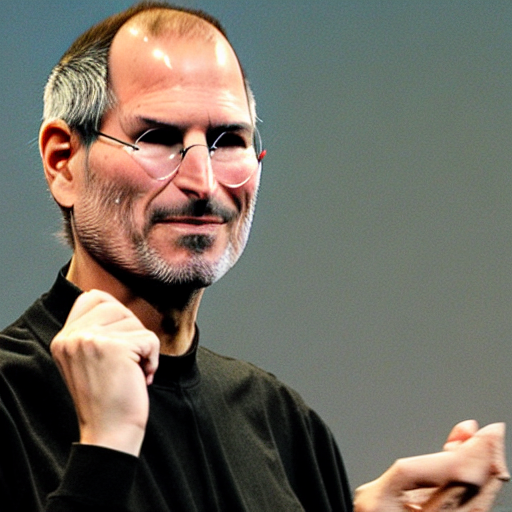

Suppressed glasses:


100%|██████████| 50/50 [00:06<00:00,  7.66it/s]


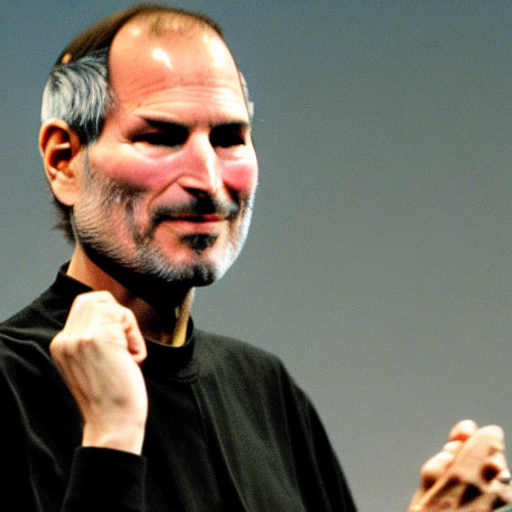

In [9]:
import torch
from models import diffusion
from types import MethodType
from utils.supp_attention import prepare_unet, AttentionStore, CCCrossAttnProcessor
from utils.prompt_emb import PromptEmbedding, EmbeddingEdit
ALPHA = 0.4

def new_key_handler(self,key):
  split_size = [*[8]*2, *[8]*self.num_additional_context]
  keys=key.split(split_size)
  new_key=torch.cat([keys[0],keys[2],keys[2],keys[3]],dim=0)
  return new_key

def new_value_handler(self,attention_probs,value,focus_on_unconditional):
  split_size = [*[8]*2, *[8]*self.num_additional_context]
  values=value.split(split_size)
  new_value=torch.cat([values[0],values[3],values[2],values[3]],dim=0)
  return torch.bmm(attention_probs, new_value)

model = diffusion('runwayml/stable-diffusion-v1-5')
seed = 2424
generator = torch.Generator('cuda').manual_seed(seed)

# Original generated image     
print("Original generated image:")   
model.pipe(prompt="a photo of (Steve Jobs)",
          num_inference_steps=50,
          generator=generator).images[0].show()

# Set monitor prompts
monitor_prompt=['a photo of (Steve Jobs) (Steve Jobs).', 'a photo of (Steve Jobs) (Steve Jobs).']
moniter_emb=[PromptEmbedding(prompt,text_model=model.pipe.text_encoder,tokenizers=model.pipe.tokenizer) for prompt in monitor_prompt]

# Set edit embedding and apply ad_delta
edit=EmbeddingEdit(dim=768)

# Appoximate delta:
edit.delta = PromptEmbedding(prompt="glasses",text_model=model.pipe.text_encoder,tokenizers=model.pipe.tokenizer).get_word_emb("glasses") 

# Adapt delta
edit(moniter_emb[0], "Steve Jobs", alpha=ALPHA, order=1) 
edit(moniter_emb[1], "Steve Jobs", alpha=-1*ALPHA, order=1)

# Set for generation
prompt_emb=model.prompt('a photo of (Steve Jobs).')
generator = torch.Generator('cuda').manual_seed(seed)

# Register unet
attention_store = AttentionStore(moniter_emb, average=True)

attention_store.key_handler=MethodType(new_key_handler,attention_store)                                  
attention_store.value_handler=MethodType(new_value_handler,attention_store)

prepare_unet(model.pipe.unet,attention_store,
              filter_set=[], 
              self_attn=False, 
              cross_attn=True,  
              CrossAttnProcessor=CCCrossAttnProcessor, )

# Generate image      
print("Suppressed glasses:")   
model.pipe(prompt_embeds=prompt_emb.embedding,
          num_inference_steps=50,
          generator=generator).images[0].show()

# Unregister unet
prepare_unet(model.pipe.unet,None,self_attn=False,cross_attn=True)